In [1]:
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
from statsmodels.api import OLS, add_constant
from statsmodels.api import stats as api_stats
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pp
from IPython.display import set_matplotlib_formats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import math
pd.options.display.max_rows = 100
set_matplotlib_formats('png')
REG_ROUND = 4
SPEC_ROUND = 6

In [2]:
def zStatistic(confidence, tails='both'):
    zDist = stats.norm(0, 1).ppf
    zStatistic = zDist((1 - confidence) / 2)
    if(tails == 'both'):
        return zStatistic, -zStatistic
    if(tails == 'left'):
        return zStatistic
    return -zStatistic

def tStatistic(confidence, dOF, tails='both'):
    tDist = stats.t(dOF).ppf
    tStatistic = tDist((1 - confidence) / 2)
    if(tails == 'both'):
        return tStatistic, -tStatistic
    if(tails == 'left'):
        return tStatistic
    return -tStatistic

def confInterval(statistics, mean, n, std):
    marginErr = std / math.sqrt(n)
    conf_int = []
    for statistic in statistics:
        conf_int.append(mean + statistic * marginErr)
    return conf_int

def combinedTConfInterval(confidence, samp1, samp2, tails='both'):
    tStats = tStatistic(confidence, samp1.size + samp2.size - 2, tails=tails)
    sp = (((samp1.size - 1) * samp1.var(ddof=1)) + ((samp2.size - 1) * samp2.var(ddof=1))) / (samp1.size + samp2.size - 2)
    se = math.sqrt(sp) * math.sqrt((1 / samp1.size) + (1 / samp2.size))
    
    combMean = (samp1 - samp2).mean()
    conf_int = []
    for tStat in tStats:
        conf_int.append(combMean + tStat * se)
    return conf_int

def proportionInterval(confidence, p, n):
    zStats = zStatistic(confidence)
    se = math.sqrt((p * (1 - p)) / n)
    confInt = []
    for stat in zStats:
        confInt.append(p + (stat * se))
    return confInt

def combinedProportionInterval(confidence, p1, p2, n1, n2):
    zStats = zStatistic(confidence)
    se = math.sqrt(((p1 * (1 - p1)) / n1) + ((p2 * (1 - p2)) / n2))
    conf_int = []
    for stat in zStats:
        conf_int.append((p1 - p2) + stat * se)
    return conf_int
    

In [3]:
df = pd.read_csv("WhiteWineQuality.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


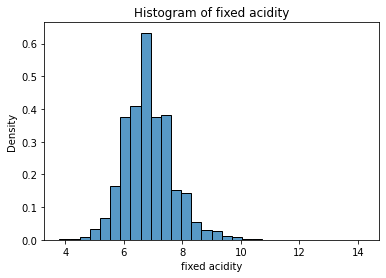

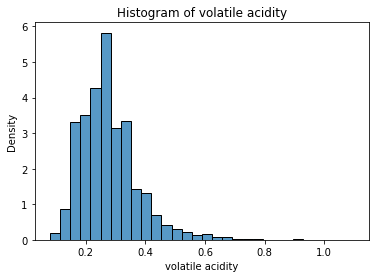

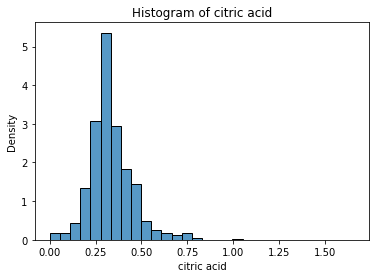

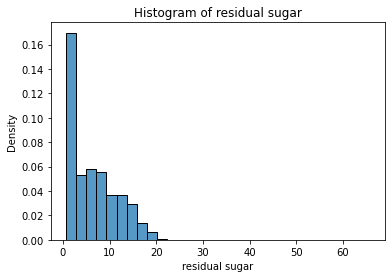

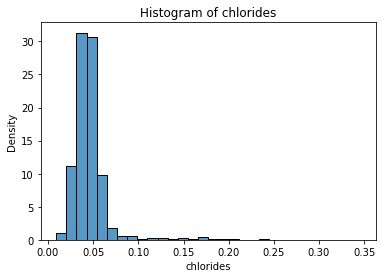

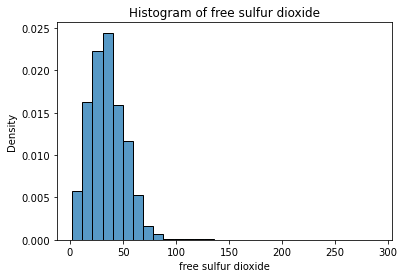

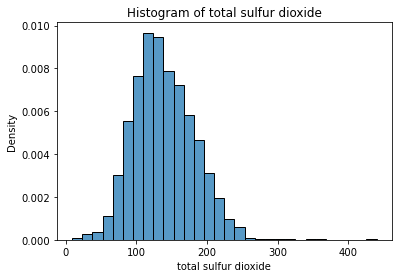

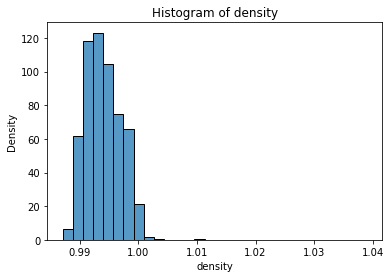

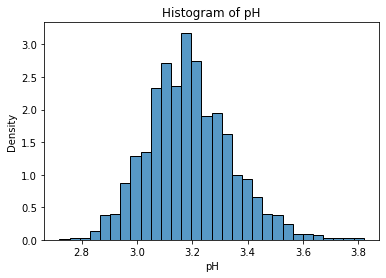

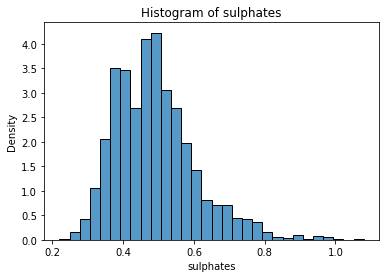

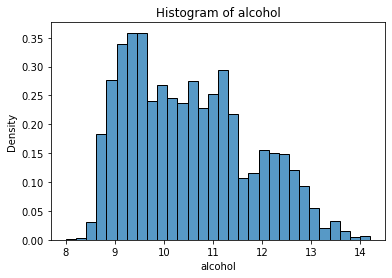

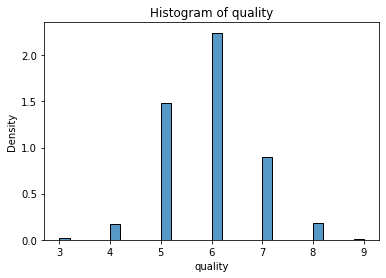

In [4]:
categories = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
              'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 
              'sulphates', 'alcohol', 'quality']

for row in range(len(categories)):
    category = categories[row]
    sns.histplot(data=df, x=category, stat='density', bins = 30)
    pp.title(f'Histogram of {category}')
    pp.show()

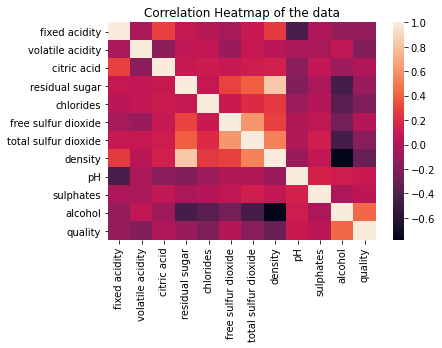

In [5]:
sns.heatmap(data=df.corr())
pp.title(f'Correlation Heatmap of the data')
pp.show()

In [6]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


Only some of the features appear to be too heavily correlated at first glance. As far as positive relationships go, residual sugar & density, free sulfur dioxide & total sulfur dioxide, and total sulfur dioxide & density have a somewhat strong relationship, at 0.838, 0.616, and 0.530 respectively. 

On the flipside, with negative relationships only really alcohol & density has a strong relationship, with a correlation of -0.780.


In [7]:
scaler = skp.StandardScaler()
scaled = scaler.fit_transform(df.values)
scaled_df = pd.DataFrame(data=scaled, columns=df.columns)
scaled_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152,0.13787
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276,0.13787
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667,0.13787
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,0.13787
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,0.13787


Scaled by a normal distribution, as it converts the numbers to z-scores (number of standard deviations away from the mean)

In [8]:
print('rating\toccurrences')
df['quality'].value_counts()

rating	occurrences


6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

Regression, since the quality is an increasing metric and can be modeled linearly.

### Question 2

In [9]:
quality_col = df['quality']
df = scaled_df
df['quality'] = quality_col
train, test = train_test_split(df, test_size=0.2)

In [10]:
# original rating occurrences
original_ratings = df['quality'].value_counts()

# train rating occurrences
train_ratings = train['quality'].value_counts()

# test rating occurrences
test_ratings = test['quality'].value_counts()

original_ratings
test_ratings
train_ratings.iloc[0]
train_props = train_ratings / train_ratings.sum()
test_props = test_ratings / test_ratings.sum()
original_props = original_ratings / original_ratings.sum()

print(f"proportion distribution of quality ratings for:\
      \nTraining Set: \n{train_props}\n\nTesting Set:\n{test_props}\n\nOriginal (Combined) Set: \n{original_props}")

proportion distribution of quality ratings for:      
Training Set: 
6    0.448188
5    0.295304
7    0.179684
8    0.038540
4    0.032925
3    0.004339
9    0.001021
Name: quality, dtype: float64

Testing Set:
6    0.451020
5    0.306122
7    0.179592
4    0.034694
8    0.024490
3    0.003061
9    0.001020
Name: quality, dtype: float64

Original (Combined) Set: 
6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64


In [11]:
# baseline wine quality prediction = mean of actual results
print(f'baseline qine quality prediction: {round(df["quality"].mean(), REG_ROUND)}')

baseline qine quality prediction: 5.8779


### Question 3

In [12]:
# lin_reg = linear_model.LinearRegression()

trainY = train['quality']
trainX = add_constant(train.drop('quality', axis=1), prepend=False)

# model = lin_reg.fit(trainX, trainY)

model = OLS(trainY, trainX)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     139.4
Date:                Mon, 12 Apr 2021   Prob (F-statistic):          4.71e-271
Time:                        03:03:19   Log-Likelihood:                -4463.6
No. Observations:                3918   AIC:                             8951.
Df Residuals:                    3906   BIC:                             9026.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.0526      0.019      2.722      0.007       0.015       0.091
volatile acidity        -0.1930      0.013    -15.076      0.000      -0.218      -0.168
citric acid             -0.0039      0.013     -0.299      0.765      -0.029       0.022
residual sugar           0.3799      0.042      9.093      0.000       0.298       0.462
chlorides               -0.0060      0.014     -0.446      0.655      -0.033       0.020
free sulfur dioxide      0.0780      0.017      4.622      0.000       0.045       0.111
total sulfur dioxide    -0.0183      0.018     -1.005      0.315      -0.054       0.017
density                 -0.4016      0.062     -6.521      0.000      -0.522      -0.281
pH                       0.0964      0.018      5.447      0.000       0.062       0.131
sulphates                0.0743      0.013      5.807      0.000       0.049       0.099
alcohol                  0.2623      0.032      8.092      0.000       0.199       0.326
const                    5.8826      0.012    486.165      0.000       5.859       5.906
==============================================================================
Omnibus:                       89.020   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.562
Skew:                           0.111   Prob(JB):                     2.28e-40
Kurtosis:                       4.034   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the p-values of each parameter, all are significant at the 95% confidence leve EXCEPT for citric acid, chlorides, and total sulfur dioxide.

### Question 4

In [13]:
residual_df = pd.DataFrame(res.resid, columns=['residual'])
residual_df.describe()

,residual
count,3.918000e+03
mean,-1.758766e-14
std,7.561151e-01
min,-3.511841e+00
25%,-4.936865e-01
50%,-3.865923e-02
75%,4.637125e-01
max,3.109791e+00


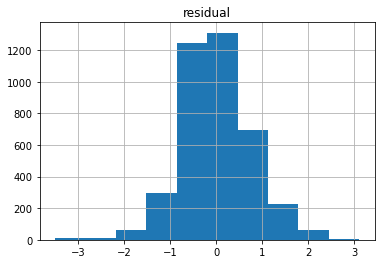

In [14]:
residual_df.hist()
pp.show()

Most of the residuals are clustered around 0. There are a few outliers, and the distribution itself is very normal-like in its shape.

In [15]:
# residuals degrees of freedon
print(f'degrees of freedom: {res.df_resid}')
print(" -- standard error -- ")
res.bse

degrees of freedom: 3906.0
 -- standard error -- 


fixed acidity           0.019342
volatile acidity        0.012802
citric acid             0.012998
residual sugar          0.041785
chlorides               0.013524
free sulfur dioxide     0.016885
total sulfur dioxide    0.018197
density                 0.061583
pH                      0.017701
sulphates               0.012788
alcohol                 0.032416
const                   0.012100
dtype: float64

Looking at the standard error, all of them seem fairly low. The most notable ones are density, alcohol, and residual sugar, which have around 5x, 3x, and 2x the standard error of other parameters. 

In [16]:
print('-- estimated parameters --')
res.params

-- estimated parameters --


fixed acidity           0.052646
volatile acidity       -0.192996
citric acid            -0.003885
residual sugar          0.379937
chlorides              -0.006038
free sulfur dioxide     0.078036
total sulfur dioxide   -0.018288
density                -0.401557
pH                      0.096408
sulphates               0.074265
alcohol                 0.262320
const                   5.882587
dtype: float64

In [17]:
print('-- parameter P-values --')
res.pvalues.sort_values()

-- parameter P-values --


const                   0.000000e+00
volatile acidity        5.791287e-50
residual sugar          1.503285e-19
alcohol                 7.743539e-16
density                 7.899597e-11
sulphates               6.858715e-09
pH                      5.452291e-08
free sulfur dioxide     3.928151e-06
fixed acidity           6.521973e-03
total sulfur dioxide    3.149724e-01
chlorides               6.552886e-01
citric acid             7.650644e-01
dtype: float64

citric acid, total sulfur dioxide, and chlorides seem to be the least significant, as their p-values are the highest, and are not low enough to support a rejection of the null hypothesis at the 95% confidence level.

In [18]:
conf = res.conf_int()
conf.columns = ['lower bound', 'upper bound']
conf['parameter'] = res.params
print('parameter confidence intervals')
conf

parameter confidence intervals


,lower bound,upper bound,parameter
fixed acidity,0.014724,0.090568,0.052646
volatile acidity,-0.218095,-0.167898,-0.192996
citric acid,-0.029368,0.021599,-0.003885
residual sugar,0.298014,0.461859,0.379937
chlorides,-0.032553,0.020477,-0.006038
free sulfur dioxide,0.044933,0.111139,0.078036
total sulfur dioxide,-0.053964,0.017389,-0.018288
density,-0.522296,-0.280819,-0.401557
pH,0.061705,0.131112,0.096408
sulphates,0.049192,0.099337,0.074265


Two-tailed, since the parameter estimate could over or undershoot how important the parameter is in relation to predicting quality.

In [19]:
r_squared = res.rsquared
r_squared_adj = res.rsquared_adj

print(f'R squared: {round(r_squared, SPEC_ROUND)}\nR squared (adjusted): {round(r_squared_adj, SPEC_ROUND)}')

R squared: 0.281965
R squared (adjusted): 0.279943


In [20]:
train_copy = train.copy()
train_copy.columns = ['fixed_acid', 'volatile_acid', 'citric', 'sugar', 'chlorides', 
                      'free_sulfur', 'total_sulfur', 'density', 'ph', 'sulphates', 'alc', 
                      'quality']
buildStr = f'{train_copy.columns[-1]} ~ '
for thing in train_copy.columns[:len(train_copy.columns) - 2]:
    buildStr += f'{thing} + '
buildStr += train_copy.columns[-2]
avon_calc = ols(buildStr, data=train_copy).fit()
anova_lm(avon_calc)

,df,sum_sq,mean_sq,F,PR(>F)
fixed_acid,1.0,36.420248,36.420248,63.525164,2.060703e-15
volatile_acid,1.0,130.607320,130.607320,227.808754,4.511495e-50
citric,1.0,0.095644,0.095644,0.166825,6.829712e-01
sugar,1.0,18.393608,18.393608,32.082619,1.583968e-08
chlorides,1.0,107.687179,107.687179,187.830836,8.636314e-42
free_sulfur,1.0,2.876166,2.876166,5.016685,2.516023e-02
total_sulfur,1.0,60.610662,60.610662,105.718725,1.738866e-24
density,1.0,356.962588,356.962588,622.623621,1.222482e-127
ph,1.0,91.709846,91.709846,159.962748,5.792919e-36
sulphates,1.0,36.478432,36.478432,63.626650,1.958845e-15


In [21]:
fStat = res.fvalue
print(f'f-statistic: {round(fStat, REG_ROUND)}')

f-statistic: 139.4407


In [22]:
print(f'log likelihood: {round(res.llf, SPEC_ROUND)}\nAIC: {round(res.aic, SPEC_ROUND)}')
p = train.shape[1]
simplified_aic = train.shape[0] * np.log(res.mse_model) * (2 * p)
# Question 4 Last Part -- ExtractAIC = simplified AIC for the model --> n * ln(sse / n) * 2*p
print(f'ExtracAIC (simplified AIC) of the model: {round(simplified_aic, SPEC_ROUND)}')

log likelihood: -4463.578291
AIC: 8951.156583
ExtracAIC (simplified AIC) of the model: 411985.082158


### Question 5

In [23]:
x = trainX
y = trainY

x = x.values
A = np.linalg.inv(x.transpose() @ x)
A
thetaHat = np.matmul(np.matmul(A, x.transpose()), y)
thetaComparison = pd.DataFrame()
thetaComparison['normal equations'] = thetaHat
thetaComparison['actual'] = res.params.values
thetaComparison.set_index(res.params.index)

,normal equations,actual
fixed acidity,0.052646,0.052646
volatile acidity,-0.192996,-0.192996
citric acid,-0.003885,-0.003885
residual sugar,0.379937,0.379937
chlorides,-0.006038,-0.006038
free sulfur dioxide,0.078036,0.078036
total sulfur dioxide,-0.018288,-0.018288
density,-0.401557,-0.401557
pH,0.096408,0.096408
sulphates,0.074265,0.074265


Clearly, the calculated and actual theta hat values are virtually the same.

### Question 6

In [24]:
gradient_df = df.drop('quality', axis=1)
gradient_df['constant'] = 1
y = df['quality'].values
x = gradient_df.values

def solver(error, alpha):
    result = (alpha * error)
    return result

def sum_errors(x, y, param_i, params):
    errs = []
    for i in range(len(x)):
        yCompute = np.dot(x[i], params)
        curr_err = yCompute - y[i]
        errs.append(curr_err * x[i, param_i])
    return sum(errs) / len(x)

def compute_error(x, y, params):
    diffs = []
    for i in range(len(x)):    
        diff = (np.dot(x[i], params) - y[i]) ** 2
        diffs.append(diff)
    return sum(diffs) / (2 * len(x))

def gradient_solver(x, y, alpha, tolerance, num_epochs=10):
    params = np.ones(len(x[0]))
    error = np.inf
    epoch = 0
    while abs(error) > tolerance and epoch < num_epochs:
        for i in range(len(params)):
            curr_err = sum_errors(x, y, i, params)
            params[i] -= solver(curr_err, alpha)
        epoch += 1
        error = compute_error(x, y, params)
    return params, epoch, error

alpha_value = 0.05
tolerance = 0.005
params, num_epochs_required, error = gradient_solver(x, y, alpha_value, tolerance, num_epochs=500)
# gradient_df.head()

In [25]:
thetaComparison['gradient descent'] = params
thetaComparison.set_index(res.params.index)

,normal equations,actual,gradient descent
fixed acidity,0.052646,0.052646,-0.019863
volatile acidity,-0.192996,-0.192996,-0.195186
citric acid,-0.003885,-0.003885,-0.001576
residual sugar,0.379937,0.379937,0.198058
chlorides,-0.006038,-0.006038,-0.016625
free sulfur dioxide,0.078036,0.078036,0.077134
total sulfur dioxide,-0.018288,-0.018288,-0.027977
density,-0.401557,-0.401557,-0.116209
pH,0.096408,0.096408,0.041705
sulphates,0.074265,0.074265,0.053746


In [26]:
print(f"steps required: {num_epochs_required}")

steps required: 500


### Question 7

In [27]:
prediction_df = pd.DataFrame()
testY = test['quality']
testX = test.drop('quality', axis=1)
testX['constant'] = 1
prediction_df['OLS predicted results'] = res.predict(testX)
prediction_df['actual results'] = test['quality']

prediction = res.get_prediction(testX).summary_frame()


prediction_df['lower bound'] = prediction['mean_ci_lower']
prediction_df['upper bound'] = prediction['mean_ci_upper']

In [28]:
print("OLS results & Comparison")
prediction_df.head(10)

OLS results & Comparison


,OLS predicted results,actual results,lower bound,upper bound
3279,6.161897,6,6.090808,6.232986
3200,6.506431,7,6.420343,6.592518
2610,5.721084,5,5.659334,5.782833
758,6.197658,7,6.076910,6.318407
1627,4.900832,5,4.806422,4.995242
733,5.586685,6,5.525555,5.647814
3914,5.999597,7,5.947313,6.051882
1163,5.506194,6,5.314412,5.697975
3375,5.865056,6,5.800733,5.929379
504,5.678658,6,5.615506,5.741809


In [29]:
testX.head()
test.head(10)['quality']

3279    6
3200    7
2610    5
758     7
1627    5
733     6
3914    7
1163    6
3375    6
504     6
Name: quality, dtype: int64

In [30]:
def compute_error(x, y, params):
    diffs = []
    for i in range(len(x)):    
        diff = (np.dot(x[i], params) - y[i]) ** 2
        diffs.append(diff)
    return sum(diffs) / (2 * len(x))

yActual = prediction_df['actual results'].values
yPredict = prediction_df['OLS predicted results'].values
errs = []
for i in range(len(yActual)):
    err = (yActual[i] - yPredict[i]) ** 2
    errs.append(err)
mse = sum(errs) / (2 * len(yActual))
root_mse = np.sqrt(mse)
print(f'mse: {round(mse, SPEC_ROUND)}\nroot mse: {round(root_mse, SPEC_ROUND)}')

mse: 0.265536
root mse: 0.515302


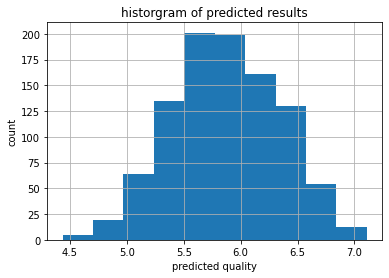

In [31]:
ax = prediction_df['OLS predicted results'].hist()
ax.set_title('historgram of predicted results')
ax.set_ylabel('count')
ax.set_xlabel('predicted quality')
pp.show()

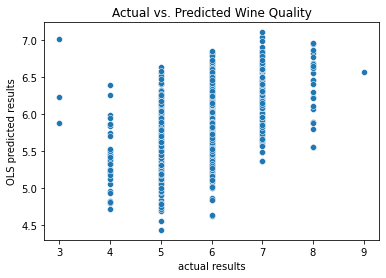

In [32]:
sns.scatterplot(data=prediction_df, x='actual results', y='OLS predicted results')
pp.title('Actual vs. Predicted Wine Quality')
pp.show()

Yes, you can see the distribution of predicted ratings for each actual rating category.

### Question 8

In [33]:
def predict(params, testX):
    results = []
    for obs in testX:
        predicted = np.dot(params, obs)
        results.append(predicted)
    return results

results = predict(thetaComparison['normal equations'].values, testX.values)
new_predict_df = prediction_df.drop(['lower bound', 'upper bound'], axis=1)
new_predict_df['direct solver prediction'] = results
new_predict_df['error'] = new_predict_df['actual results'] - new_predict_df['direct solver prediction']
print('OLS vs. Direct Solver vs. Actual Results Comparison')
new_predict_df.head()

OLS vs. Direct Solver vs. Actual Results Comparison


,OLS predicted results,actual results,direct solver prediction,error
3279,6.161897,6,6.161897,-0.161897
3200,6.506431,7,6.506431,0.493569
2610,5.721084,5,5.721084,-0.721084
758,6.197658,7,6.197658,0.802342
1627,4.900832,5,4.900832,0.099168


In [34]:
new_predict_df['error'].describe()

count    980.000000
mean      -0.023378
std        0.728743
min       -4.020146
25%       -0.498061
50%       -0.060743
75%        0.471983
max        2.440633
Name: error, dtype: float64

In [35]:
e = new_predict_df['error']
sse = np.dot(e, e)
rse = np.sqrt((sse / (new_predict_df.shape[0] - len(params))))
print(f'residual degrees of freedom: {new_predict_df.shape[0] - len(params)}')
print(f'residual standard error: {round(rse, SPEC_ROUND)}')

residual degrees of freedom: 968
residual standard error: 0.73325


In [36]:
c_mat = A * (sse / (new_predict_df.shape[0] - len(params)))
se = np.sqrt(c_mat.diagonal())

rdof = (new_predict_df.shape[0] - len(params))
lower, upper = tStatistic(.95, rdof - 2)
t_dist = stats.t(rdof - 2)

OLS_se = res.bse
OLS_t = res.tvalues
OLS_pVals = res.pvalues
stats_df = pd.DataFrame(index=OLS_se.index)
stats_df['OLS se'] = OLS_se
stats_df['direct solver se'] = se
stats_df['OLS t'] = OLS_t
t = params / se
stats_df['direct solver t'] = t

ds_pvals = []
for index, row in stats_df.iterrows():
    ds_t = row['direct solver t']
    if ds_t > 0:
        ds_p = integrate.quad(t_dist.pdf, ds_t, np.inf)
    else:
        ds_p = integrate.quad(t_dist.pdf, -np.inf, ds_t)
    ds_pvals.append(ds_p[0])

stats_df['OLS p values'] = res.pvalues
stats_df['direct solver p values'] = ds_pvals
print("Statistic Comparison for multiple prediction methods")
stats_df

Statistic Comparison for multiple prediction methods


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5982: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


,OLS se,direct solver se,OLS t,direct solver t,OLS p values,direct solver p values
fixed acidity,0.019342,0.018731,2.721778,-1.060441,6.521973e-03,1.446045e-01
volatile acidity,0.012802,0.012397,-15.075891,-15.744496,5.791287e-50,3.443653e-50
citric acid,0.012998,0.012587,-0.298858,-0.125178,7.650644e-01,4.502042e-01
residual sugar,0.041785,0.040464,9.092666,4.894611,1.503285e-19,5.769079e-07
chlorides,0.013524,0.013097,-0.446462,-1.269391,6.552886e-01,1.023037e-01
free sulfur dioxide,0.016885,0.016351,4.621743,4.717401,3.928151e-06,1.370341e-06
total sulfur dioxide,0.018197,0.017622,-1.004972,-1.587642,3.149724e-01,5.634728e-02
density,0.061583,0.059637,-6.520556,-1.948611,7.899597e-11,2.581555e-02
pH,0.017701,0.017141,5.446539,2.432984,5.452291e-08,7.577766e-03
sulphates,0.012788,0.012384,5.807195,4.339849,6.858715e-09,7.879607e-06


### Question 9

In [37]:
params = np.array(params, dtype='float32')
testX = np.array(testX, dtype='float32')
results = predict(params, testX)

grad_predict_df = new_predict_df.drop('error', axis=1)
grad_predict_df['gradient results'] = results
grad_predict_df = grad_predict_df[['OLS predicted results', 'direct solver prediction', 'gradient results', 'actual results']]
print("Test Set prediction comparison")
grad_predict_df.head(20)

Test Set prediction comparison


,OLS predicted results,direct solver prediction,gradient results,actual results
3279,6.161897,6.161897,6.171608,6
3200,6.506431,6.506431,6.535079,7
2610,5.721084,5.721084,5.710717,5
758,6.197658,6.197658,6.078450,7
1627,4.900832,4.900832,4.973057,5
733,5.586685,5.586685,5.589146,6
3914,5.999597,5.999597,5.959065,7
1163,5.506194,5.506194,5.479843,6
3375,5.865056,5.865056,5.906379,6
504,5.678658,5.678658,5.626194,6


### Question 10

In [38]:
# r_squared = ssm / sst = 1 - (sse / sst)
# r_squared_adj = 1 - (sse / sst) * (n - 1 / n - p)
# F = (1 - (sse / sst)) * (n - p / p - 1)
# AIC = −2 * ll + 2 * (p + 1)
# llh = (n / 2) * log(2 * pi) - (n / 2) * log(sse) - (sse / s(qrt(sse / n) * sse))
# sse = sum of squared errors
# sst = sum of (y - yMeanOfActual)^2

sse = sum([err ** 2 for err in (grad_predict_df['direct solver prediction'] - grad_predict_df['actual results'])]) / grad_predict_df.shape[0]
sse_s = sum([err ** 2 for err in (grad_predict_df['direct solver prediction'] - grad_predict_df['actual results'])])
actual_mean = grad_predict_df['actual results'].describe()['mean']
sst = sum([diff ** 2 for diff in (grad_predict_df['actual results'] - actual_mean)])
r_sq = 1 - (sse_s / sst)
r_sq_adj = r_sq * ((grad_predict_df.shape[0] - 1) / (grad_predict_df.shape[0] - stats_df.shape[0]))
F = r_sq * ((grad_predict_df.shape[0] - stats_df.shape[0]) / (stats_df.shape[0] - 1))
log_lik = -(grad_predict_df.shape[0]/2.0) * (np.log(2 * math.pi)) - (grad_predict_df.shape[0]/2.0) * (np.log(sse_s / (grad_predict_df.shape[0] - len(params)))) - (sse_s / ((sse_s / (grad_predict_df.shape[0] - len(params)) * 2)))
aic = -2 * log_lik + (stats_df.shape[0] + 1)
f_dist = stats.f(grad_predict_df.shape[0] - 1, stats_df.shape[0] - grad_predict_df.shape[0]).pdf
F_pval = integrate.quad(f_dist, F, np.inf)

print(f'r_squared = {round(r_sq, SPEC_ROUND)}')
print(f'r_squared adjusted = {round(r_sq_adj, SPEC_ROUND)}')
print(f'F = {round(F, SPEC_ROUND)}')
print(f'P-value: {F_pval[0]} -- approximately 0')
print(f'AIC = {round(aic, SPEC_ROUND)}')
print(f'log likelihood = {round(log_lik, SPEC_ROUND)}')
# Question 10 -- P Value: use F-value as F-statistic and find area under F-distribution from F-statistic -> +/- Infinity

r_squared = 0.278196
r_squared adjusted = 0.281357
F = 24.481254
P-value: nan -- approximately 0
AIC = 2173.992213
log likelihood = -1080.496107


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


### Question 11

In [39]:
model2 = OLS(trainY, trainX)
full = model2.fit()
full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     139.4
Date:                Mon, 12 Apr 2021   Prob (F-statistic):          4.71e-271
Time:                        03:05:33   Log-Likelihood:                -4463.6
No. Observations:                3918   AIC:                             8951.
Df Residuals:                    3906   BIC:                             9026.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.0526      0.019      2.722      0.007       0.015       0.091
volatile acidity        -0.1930      0.013    -15.076      0.000      -0.218      -0.168
citric acid             -0.0039      0.013     -0.299      0.765      -0.029       0.022
residual sugar           0.3799      0.042      9.093      0.000       0.298       0.462
chlorides               -0.0060      0.014     -0.446      0.655      -0.033       0.020
free sulfur dioxide      0.0780      0.017      4.622      0.000       0.045       0.111
total sulfur dioxide    -0.0183      0.018     -1.005      0.315      -0.054       0.017
density                 -0.4016      0.062     -6.521      0.000      -0.522      -0.281
pH                       0.0964      0.018      5.447      0.000       0.062       0.131
sulphates                0.0743      0.013      5.807      0.000       0.049       0.099
alcohol                  0.2623      0.032      8.092      0.000       0.199       0.326
const                    5.8826      0.012    486.165      0.000       5.859       5.906
==============================================================================
Omnibus:                       89.020   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.562
Skew:                           0.111   Prob(JB):                     2.28e-40
Kurtosis:                       4.034   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
print(f'dfe: {full.df_model}')
print(f'dfm: {full.df_resid + 1}')
print(f'F value: {round(full.fvalue, SPEC_ROUND)}')
print(f'F statistic P value: {full.f_pvalue, SPEC_ROUND} -- basically 0')
print(f'log-likelihood: {round(full.llf)}')
print(f'AIC: {round(full.aic, SPEC_ROUND)}')
full_sse = np.dot(full.resid, full.resid)
simp_aic = grad_predict_df.shape[0] * np.log(full_sse / grad_predict_df.shape[0]) * (2 * stats_df.shape[0]) # n * ln(sse / n) * 2*p
print(f'simplified AIC: {round(simp_aic, SPEC_ROUND)}')

dfe: 11.0
dfm: 3907.0
F value: 139.440742
F statistic P value: (4.705106358777537e-271, 6) -- basically 0
log-likelihood: -4464
AIC: 8951.156583
simplified AIC: 19437.053187


### Question 12

In [41]:
print(f'number of steps required: {num_epochs_required}')
print(f'alpha used: {alpha_value}')
print(f'tolerance used: {tolerance}')
print(f'final error: {round(error, SPEC_ROUND)}')
repeat_df = pd.DataFrame()
repeat_df['OLS Params'] = full.params
repeat_df['Gradient Descent Params'] = params
print("Paramaters from Full (OLS) and Gradient Descent Comparison:")
repeat_df

number of steps required: 500
alpha used: 0.05
tolerance used: 0.005
final error: 0.283563
Paramaters from Full (OLS) and Gradient Descent Comparison:


,OLS Params,Gradient Descent Params
fixed acidity,0.052646,-0.019863
volatile acidity,-0.192996,-0.195186
citric acid,-0.003885,-0.001576
residual sugar,0.379937,0.198058
chlorides,-0.006038,-0.016625
free sulfur dioxide,0.078036,0.077134
total sulfur dioxide,-0.018288,-0.027977
density,-0.401557,-0.116209
pH,0.096408,0.041705
sulphates,0.074265,0.053746


### Question 13

In [42]:
samples = grad_predict_df.sample(20)
print('predictions from Full (OLS), direct solver, and gradient descent vs. actual results comparison:')
samples

predictions from Full (OLS), direct solver, and gradient descent vs. actual results comparison:


,OLS predicted results,direct solver prediction,gradient results,actual results
1212,5.820316,5.820316,5.888213,6
2772,6.832267,6.832267,6.788105,7
4261,6.501427,6.501427,6.493754,7
993,5.525348,5.525348,5.594263,4
3601,5.740574,5.740574,5.743992,7
4213,5.241689,5.241689,5.250098,4
1109,5.221761,5.221761,5.195518,4
1214,5.620262,5.620262,5.646428,6
3543,6.005424,6.005424,5.998653,6
2272,5.991609,5.991609,5.982680,6


In [43]:
error_df = pd.DataFrame()
error_df['OLS error'] = grad_predict_df['actual results'] - grad_predict_df['OLS predicted results']
error_df['direct solver error'] = grad_predict_df['actual results'] - grad_predict_df['direct solver prediction']
error_df['gradient error'] = grad_predict_df['actual results'] - grad_predict_df['gradient results']
print('error from Full (OLS), direct solver, and gradient descent comparison:')
error_samples = error_df.sample(20)
error_samples

error from Full (OLS), direct solver, and gradient descent comparison:


,OLS error,direct solver error,gradient error
4110,-0.727866,-0.727866,-0.723493
3200,0.493569,0.493569,0.464921
334,-0.972837,-0.972837,-0.984795
2703,-0.662534,-0.662534,-0.640303
3869,-0.007686,-0.007686,-0.070162
2824,0.432111,0.432111,0.421631
2811,-0.808949,-0.808949,-0.845561
2658,0.552311,0.552311,0.568085
1491,-1.009558,-1.009558,-1.028338
2575,0.184558,0.184558,0.220688


In [44]:
gradient_rse = sum([error ** 2 for error in error_df['gradient error']]) / (error_df.shape[0] - stats_df.shape[0])
print(f'gradient rse: {round(gradient_rse, SPEC_ROUND)}')

gradient rse: 0.542341


### Question 14

In [45]:
test = test.reset_index()

In [46]:
OLS_params = full.params.values
direct_solver_params = thetaComparison['normal equations'].values
gradient_params = params

OLS_prediction = predict(OLS_params, testX)
direct_solver_prediction = predict(direct_solver_params, testX)
gradient_prediction = predict(gradient_params, testX)

test_predict_df = pd.DataFrame()
test_predict_df['OLS prediction'] = OLS_prediction
test_predict_df['direct solver prediction'] = direct_solver_prediction
test_predict_df['gradient prediction'] = gradient_prediction
test_predict_df = test_predict_df.reset_index()
test_predict_df['actual'] = test['quality']
print("testing set prediction comparison between Full (OLS), direct solver, and gradient descent vs. actual results")
test_predict_df.sample(20)
# Question 14 -- Baseline Estimation: Null hypothesis: Can use Mean or Median of whatever data set you are on

testing set prediction comparison between Full (OLS), direct solver, and gradient descent vs. actual results


,index,OLS prediction,direct solver prediction,gradient prediction,actual
523,523,5.612608,5.612608,5.550314,6
973,973,6.316533,6.316533,6.314938,6
148,148,5.697524,5.697524,5.727462,6
486,486,6.095089,6.095089,6.063494,6
802,802,6.986644,6.986644,7.014407,7
166,166,5.726734,5.726734,5.788298,5
156,156,6.638494,6.638494,6.675165,8
786,786,5.354981,5.354981,5.400952,5
46,46,5.919166,5.919166,5.896207,5
501,501,5.364874,5.364874,5.387971,7


In [47]:
test_error_df = pd.DataFrame()

test_error_df['baseline error'] = grad_predict_df['actual results'] - df["quality"].mean()
test_error_df['OLS error'] = grad_predict_df['actual results'] - grad_predict_df['OLS predicted results']
test_error_df['direct solver error'] = grad_predict_df['actual results'] - grad_predict_df['direct solver prediction']
test_error_df['gradient error'] = grad_predict_df['actual results'] - grad_predict_df['gradient results']

OLS_rse = sum([error ** 2 for error in test_error_df['OLS error']]) / (error_df.shape[0] - stats_df.shape[0])
print(f'OLS rse: {round(OLS_rse, SPEC_ROUND)}')

direct_solver_rse = sum([error ** 2 for error in test_error_df['direct solver error']]) / (error_df.shape[0] - stats_df.shape[0])
print(f'direct solver rse: {round(direct_solver_rse, SPEC_ROUND)}')

gradient_rse = sum([error ** 2 for error in test_error_df['gradient error']]) / (error_df.shape[0] - stats_df.shape[0])
print(f'gradient rse: {round(gradient_rse, SPEC_ROUND)}')

baseline_rse = sum([error ** 2 for error in test_error_df['baseline error']]) / (error_df.shape[0] - stats_df.shape[0])
print(f'baseline rse: {round(baseline_rse, SPEC_ROUND)}')

OLS rse: 0.537655
direct solver rse: 0.537655
gradient rse: 0.542341
baseline rse: 0.745848


Yes, the model does improve the accuracy, however only really by about 0.2. This means that a strictly linear relationship may not be the best means of predicting wine quality in relation to other methods.

### Question 15

In [48]:
# r_squared = ssm / sst = 1 - (sse / sst)
# r_squared_adj = 1 - (sse / sst) * (n - 1 / n - p)
# F = (1 - (sse / sst)) * (n - p / p - 1)
# AIC = −2 * ll + 2 * (p + 1)
# llh = (n / 2) * log(2 * pi) - (n / 2) * log(sse) - (sse / s(qrt(sse / n) * sse))
# sse = sum of squared errors
# sst = sum of (y - yMeanOfActual)^2

divisor = grad_predict_df.shape[0] - len(params)
divisor2 = len(params) - 1
divisor3 = grad_predict_df.shape[0] - 1
# sse, ssm, sst

OLS_sse = sum([error ** 2 for error in grad_predict_df['OLS predicted results'] - grad_predict_df['actual results']])
OLS_ssm = sum([error ** 2 for error in grad_predict_df['OLS predicted results'] - grad_predict_df['actual results'].mean()])
sst = sum([error ** 2 for error in grad_predict_df['actual results'] - grad_predict_df['actual results'].mean()])

ds_sse = sum([error ** 2 for error in grad_predict_df['direct solver prediction'] - grad_predict_df['actual results']])
ds_ssm = sum([error ** 2 for error in grad_predict_df['direct solver prediction'] - grad_predict_df['actual results'].mean()])

grad_sse = sum([error ** 2 for error in grad_predict_df['gradient results'] - grad_predict_df['actual results']])
grad_ssm = sum([error ** 2 for error in grad_predict_df['gradient results'] - grad_predict_df['actual results'].mean()])

# mse, msm, mst
OLS_mse = res.mse_resid
OLS_msm = OLS_ssm / divisor2
mst = sst / divisor3

ds_mse = ds_sse / divisor
ds_msm = ds_ssm / divisor2

grad_mse = grad_sse / divisor
grad_msm = grad_ssm / divisor2

# F value for model & P-value
OLS_f = (1 - (OLS_sse / sst)) * (divisor / divisor2)
ds_f = (1 - (ds_sse / sst)) * (divisor / divisor2)
grad_f = (1 - (grad_sse / sst)) * (divisor / divisor2)

f_dist = stats.f(divisor2, divisor).pdf

OLS_pval = integrate.quad(f_dist, OLS_f, np.inf)[0]
ds_pval = integrate.quad(f_dist, ds_f, np.inf)[0]
grad_pval = integrate.quad(f_dist, grad_f, np.inf)[0]

# log-likelihood, exact AIC, simplified AIC
n = grad_predict_df.shape[0]
p = len(params)
OLS_ll = -(n / 2) * np.log(2 * np.pi) - (n / 2) * np.log(OLS_mse) - (OLS_sse / (2 * OLS_mse))
OLS_aic = res.aic
OLS_simp_aic = n * np.log(OLS_sse / n) + (2 * p)

ds_ll = -(n / 2) * np.log(2 * np.pi) - (n / 2) * np.log(ds_mse) - (ds_sse / (2 * ds_mse))
ds_aic = -2 * ds_ll + (2 * p + 1)
ds_simp_aic = n * np.log(ds_sse / n) + (2 * p)

grad_ll = -(n / 2) * np.log(2 * np.pi) - (n / 2) * np.log(grad_mse) - (grad_sse / (2 * grad_mse))
grad_aic = -2 * grad_ll + (2 * p + 1)
grad_simp_aic = n * np.log(grad_sse / n) + (2 * p)

final_stats_df = pd.DataFrame()
final_stats_df['OLS predicted results'] = [OLS_sse, OLS_ssm, sst, OLS_mse, OLS_msm, mst, OLS_f, OLS_pval, OLS_ll, OLS_aic, OLS_simp_aic]
final_stats_df['direct solver predicted results'] = [ds_sse, ds_ssm, sst, ds_mse, ds_msm, mst, ds_f, ds_pval, ds_ll, ds_aic, ds_simp_aic]
final_stats_df['gradient solver predicted results'] = [grad_sse, grad_ssm, sst, grad_mse, grad_msm, mst, grad_f, grad_pval, grad_ll, grad_aic, grad_simp_aic]
final_stats_df.index = ['sse', 'ssm', 'sst', 'mse', 'msm', 'mst', 'f-statistic', 'p-value', 'log-likelihood', 'AIC', 'Simplified AIC']
print('Cumulative Statistics for various wine quality predictions')
final_stats_df

Cumulative Statistics for various wine quality predictions


,OLS predicted results,direct solver predicted results,gradient solver predicted results
sse,5.204501e+02,5.204501e+02,5.249862e+02
ssm,2.155175e+02,2.155175e+02,2.105606e+02
sst,7.210408e+02,7.210408e+02,7.210408e+02
mse,5.733200e-01,5.376551e-01,5.423411e-01
msm,1.959250e+01,1.959250e+01,1.914187e+01
mst,7.365075e-01,7.365075e-01,7.365075e-01
f-statistic,2.448125e+01,2.448125e+01,2.392764e+01
p-value,6.536477e-45,6.536477e-45,6.572603e-44
log-likelihood,-1.081859e+03,-1.080496e+03,-1.084748e+03
AIC,8.951157e+03,2.185992e+03,2.194497e+03
